<a href="https://colab.research.google.com/github/CheilaBaiao/Pantanal/blob/main/2)Mapbiomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title B2-1 — Setup (libs, Drive, config, pastas)
%pip -q install numpy pandas geopandas shapely rasterio rioxarray xarray tqdm pyyaml

import os, json, glob, time, re, yaml, warnings
from pathlib import Path
import numpy as np, pandas as pd
import geopandas as gpd

# Montar Drive
from google.colab import drive
try:
    drive.mount('/content/drive')
except Exception as e:
    print("Aviso ao montar Drive:", e)

# Pastas-base do projeto
BASE_DIR  = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
OUT_DIR   = BASE_DIR / "outputs"
LOG_DIR   = OUT_DIR / "logs"
QC_DIR    = OUT_DIR / "qc"
OUT_DIR.mkdir(parents=True, exist_ok=True)
LOG_DIR.mkdir(parents=True, exist_ok=True)
QC_DIR.mkdir(parents=True, exist_ok=True)

CONFIG_FP = BASE_DIR / "config.yaml"

# Carregar config
assert CONFIG_FP.exists(), f"config.yaml não encontrado em {CONFIG_FP}"
CONFIG = yaml.safe_load(open(CONFIG_FP))

# Parâmetros essenciais
CRS_EPSG         = int(CONFIG.get("crs_epsg", 31983))
BOUNDARY_PATH    = CONFIG.get("boundary_path")
assert BOUNDARY_PATH and Path(BOUNDARY_PATH).exists(), "Defina 'boundary_path' válido no config.yaml"

# Pasta onde ficarão os GeoTIFFs bimestrais (byte 0/1) já em 300 m
MB_OUT_FOLDER_DRIVE = "Pantanal_TippingPoints_val_mb_bi_30m"  # em /MyDrive/<pasta>
MB_OUT_DIR = Path(f"/content/drive/MyDrive/{MB_OUT_FOLDER_DRIVE}")
MB_OUT_DIR.mkdir(parents=True, exist_ok=True)

print("✔ Config carregada")
print("EPSG:", CRS_EPSG)
print("Boundary:", BOUNDARY_PATH)
print("Saída MapBiomas (Drive):", MB_OUT_DIR)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✔ Config carregada
EPSG: 31983
Boundary: /content/drive/MyDrive/Pantanal_TippingPoints/Pantanal.shp
Saída MapBiomas (Drive): /content/drive/MyDrive/Pantanal_TippingPoints_val_mb_bi_30m


In [ ]:
# @title B2-2 — Descobrir meses (bimestral) e extrair grade canônica (transform/crs/shape)
import rasterio as rio

# Preferimos herdar a grade canônica de um dos seus ópticos (300 m):
OPT_FOLDER = CONFIG.get("gee_drive_folder_optical", "Pantanal_TippingPoints_optical")
ROOTS      = [Path("/content/drive/MyDrive"), Path("/content/drive/My Drive")]
OPT_DIRS   = [r / OPT_FOLDER for r in ROOTS]
MERGE_DIRS = [r / f"{OPT_FOLDER}_merged" for r in ROOTS]

YEARS      = list(range(1985, 2022))               # 1985–2022
BIMONTHS   = ("01","03","05","07","09","11")
TARGET_YYYYMM = [f"{y}{m}" for y in YEARS for m in BIMONTHS]

def _glob_all(pat):
    s=set()
    for r in ROOTS: s |= set(glob.glob(str(r/pat)))
    return sorted(s)

def _month_file(ym: str):
    # 1) SINGLE (opt_YYYYMM.tif)
    for d in OPT_DIRS:
        fp = d / f"opt_{ym}.tif"
        if fp.exists(): return str(fp)
    # 2) MERGED (opt_YYYYMM_merged.tif)
    for d in MERGE_DIRS:
        fp = d / f"opt_{ym}_merged.tif"
        if fp.exists(): return str(fp)
    return None

found = []
for ym in TARGET_YYYYMM:
    f = _month_file(ym)
    if f: found.append((ym, f))
AVAILABLE_YYYYMM = [ym for ym, _ in found]
MISSING_YYYYMM   = sorted(set(TARGET_YYYYMM) - set(AVAILABLE_YYYYMM))

print(f"Esperados bimestres: {len(TARGET_YYYYMM)} | Disponíveis (p/ snap): {len(AVAILABLE_YYYYMM)}")
if MISSING_YYYYMM:
    print("Faltando (amostra):", MISSING_YYYYMM[:12], "…")

# Escolher 1 arquivo ótimo para extrair grade (o 1º disponível)
assert AVAILABLE_YYYYMM, "Nenhum óptico 300 m disponível para extrair a grade."
REF_FP = _month_file(AVAILABLE_YYYYMM[0])
print("Grade de referência →", REF_FP)

with rio.open(REF_FP) as src:
    REF_META = {
        "crs": src.crs, "transform": src.transform,
        "height": src.height, "width": src.width, "dtype": src.dtypes[0]
    }

assert int(REF_META["crs"].to_epsg()) == CRS_EPSG, "EPSG do óptico ≠ EPSG do config.yaml"
print("✔ Grade canônica:", REF_META["width"], "x", REF_META["height"], "|", REF_META["crs"])
print("✔ Transform:", REF_META["transform"])

# Converter Affine → crsTransform (lista de 6) p/ Export.image
A = REF_META["transform"]  # Affine(a,b,c,d,e,f) (geralmente b=d=0; e<0)
CRS_TRANSFORM = [A.a, A.b, A.c, A.d, A.e, A.f]
print("✔ crsTransform p/ EE:", CRS_TRANSFORM)

# Lista final de YYYMM a processar (por padrão usa TARGET; se quiser só os disponíveis, troque)
YMS = TARGET_YYYYMM[:]   # ou: AVAILABLE_YYYYMM[:]
print("Meses-alvo:", len(YMS), "ex.:", YMS[:6], "…")


Esperados bimestres: 222 | Disponíveis (p/ snap): 222
Grade de referência → /content/drive/MyDrive/Pantanal_TippingPoints_optical_merged/opt_198501_merged.tif
✔ Grade canônica: 1612 x 2448 | EPSG:31983
✔ Transform: | 300.00, 0.00,-1024500.00|
| 0.00,-300.00, 8228100.00|
| 0.00, 0.00, 1.00|
✔ crsTransform p/ EE: [300.0, 0.0, -1024500.0, 0.0, -300.0, 8228100.0]
Meses-alvo: 222 ex.: ['198501', '198503', '198505', '198507', '198509', '198511'] …


In [ ]:
# @title B2-3 — EE init + função bimestral nativa em 30 m (sem reduceResolution)
%pip -q install geopandas
import ee, json
import geopandas as gpd
from shapely.geometry import mapping

# Inicializa EE
try:
    ee.Initialize(project="ee-cheilabaiao")
    print("✔ EE inicializado com projeto")
except Exception:
    ee.Authenticate()
    ee.Initialize()
    print("✔ EE autenticado")

# Região: usa exatamente o boundary do config
gdf = gpd.read_file(BOUNDARY_PATH).to_crs(CRS_EPSG)
assert len(gdf) > 0, "Boundary vazio?"
REGION = ee.Geometry(mapping(gdf.geometry.unary_union), proj=f"EPSG:{CRS_EPSG}", geodesic=False)
print("✔ Região pronta")

# Asset MapBiomas Fogo (mensal)
MB_ASSET = 'projects/mapbiomas-public/assets/brazil/fire/collection4/mapbiomas_fire_collection4_monthly_burned_v1'
MB_IMG   = ee.Image(MB_ASSET)

def _safe_year_band(img: ee.Image, year: int) -> ee.Image:
    bname = f"burned_monthly_{year}"
    return ee.Image(ee.Algorithms.If(
        img.bandNames().contains(bname),
        img.select(bname),
        ee.Image(0).rename(bname)
    ))

def mb_bi_30m(yyyymm: str) -> ee.Image:
    """Máscara bimestral 0/1 em 30 m (nativo). Agregação para 300 m será offline."""
    y = int(yyyymm[:4]); m = int(yyyymm[4:6])
    by   = _safe_year_band(MB_IMG, y)
    bi30 = by.eq(m).Or(by.eq(m+1)).rename('burned_bi').toByte()
    return bi30.unmask(0).toByte()


✔ EE inicializado com projeto


/tmp/ipython-input-1904838876.py:19: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  REGION = ee.Geometry(mapping(gdf.geometry.unary_union), proj=f"EPSG:{CRS_EPSG}", geodesic=False)


✔ Região pronta


In [ ]:
# @title B2-4 — Checkpoint local (pula meses já exportados no Drive)
def _has_export(ym: str) -> bool:
    fp = MB_OUT_DIR / f"mb_bi_{ym}_30m.tif"
    return fp.exists()

YMS_PENDING = [ym for ym in YMS if not _has_export(ym)]
print(f"Já existentes: {len(YMS)-len(YMS_PENDING)} | A exportar: {len(YMS_PENDING)}")
print("A exportar (amostra):", YMS_PENDING[:12], "…")


Já existentes: 222 | A exportar: 0
A exportar (amostra): [] …


In [ ]:
# @title B2-5 — Export EE→Drive em 30 m (rápido) com checkpoint
EXPORT_FOLDER = MB_OUT_FOLDER_DRIVE
DESC_PREFIX   = "mb_bi"
CRS           = f"EPSG:{CRS_EPSG}"

def _has_30(ym: str) -> bool:
    return (MB_OUT_DIR / f"{DESC_PREFIX}_{ym}_30m.tif").exists()

YMS_PENDING_30 = [ym for ym in YMS if not _has_30(ym)]
print(f"Já em 30 m: {len(YMS)-len(YMS_PENDING_30)} | A exportar (30 m): {len(YMS_PENDING_30)}")
print("A exportar (amostra):", YMS_PENDING_30[:12], "…")

tasks = []
for ym in YMS_PENDING_30:
    img  = mb_bi_30m(ym).set({'yyyymm': ym})
    desc = f"{DESC_PREFIX}_{ym}_30m"
    task = ee.batch.Export.image.toDrive(
        image         = img,
        description   = desc,
        folder        = EXPORT_FOLDER,
        fileNamePrefix= desc,
        region        = REGION,
        crs           = CRS,     # pode omitir; manter igual por consistência de metadados
        scale         = 30,      # rápido!
        maxPixels     = 1e13,
        fileFormat    = 'GeoTIFF'  # sem COG (mais rápido para gerar)
    )
    task.start()
    tasks.append((ym, task))

print(f"⇢ {len(tasks)} exports (30 m) lançados para '{EXPORT_FOLDER}'")

# Monitor simples
pending = {t.id: (ym, t) for ym, t in tasks}
last = {}
while pending:
    done = []
    for tid, (ym, t) in pending.items():
        st = t.status(); s = st.get('state','UNKNOWN')
        if last.get(tid) != s:
            print(f"[{ym}] {s}")
            last[tid] = s
        if s in ("COMPLETED","FAILED","CANCELLED"):
            done.append(tid)
    for tid in done: pending.pop(tid, None)
    if pending: time.sleep(8)

# Log
run_log = {
    "when": time.strftime("%Y-%m-%d %H:%M:%S"),
    "export_mode": "30m_raw",
    "launched": [ym for ym, _ in tasks],
    "folder": EXPORT_FOLDER,
    "crs": CRS,
    "scale": 30,
}
with open(LOG_DIR/"nb2_mapbiomas_30m_export_log.json", "w") as f:
    json.dump(run_log, f, indent=2, ensure_ascii=False)
print("✔ Log salvo em", LOG_DIR/"nb2_mapbiomas_30m_export_log.json")



Já em 30 m: 222 | A exportar (30 m): 0
A exportar (amostra): [] …
⇢ 0 exports (30 m) lançados para 'Pantanal_TippingPoints_val_mb_bi_30m'
✔ Log salvo em /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/logs/nb2_mapbiomas_30m_export_log.json


In [ ]:
# @title B2-5b — Agregar/alinha 30 m → 300 m (gera frac e mode), com checkpoint
import rasterio as rio
from rasterio.warp import reproject, Resampling
import numpy as np

# Grade canônica (do seu óptico)
with rio.open(REF_FP) as ref:
    ref_meta = ref.meta.copy()
    ref_meta.update(count=1, dtype='float32', nodata=0.0, compress='lzw',
                    tiled=True, blockxsize=512, blockysize=512, BIGTIFF='IF_SAFER')
    ref_crs  = ref.crs
    ref_tfm  = ref.transform
    ref_h, ref_w = ref.height, ref.width

def _exists_300_frac(ym): return (MB_OUT_DIR / f"mb_bi_{ym}_300m_frac.tif").exists()
def _exists_300_mode(ym): return (MB_OUT_DIR / f"mb_bi_{ym}_300m_mode.tif").exists()

# Convertidos pendentes: precisa existir o 30 m e faltar alguma das saídas 300 m
to_process = [ym for ym in YMS if (MB_OUT_DIR / f"mb_bi_{ym}_30m.tif").exists()
              and (not _exists_300_frac(ym) or not _exists_300_mode(ym))]
print("Converter 30→300 m (faltando):", len(to_process), "| amostra:", to_process[:10])

for ym in to_process:
    src_fp = MB_OUT_DIR / f"mb_bi_{ym}_30m.tif"
    with rio.open(src_fp) as src:
        src_arr  = src.read(1).astype(np.float32)  # 0/1 como float
        src_meta = src.meta

    # 1) FRAÇÃO queimada por célula 300 m (média dos 0/1) — Resampling.average
    frac = np.zeros((ref_h, ref_w), dtype='float32')
    reproject(
        source=src_arr, destination=frac,
        src_transform=src_meta['transform'], src_crs=src_meta['crs'],
        dst_transform=ref_tfm,             dst_crs=ref_crs,
        src_nodata=0.0, dst_nodata=0.0,
        resampling=Resampling.average
    )

    # 2) MODE binário (maioria estrita) — empate (0.5) vira 0 (conservador)
    mode = (frac > 0.5).astype('uint8')

    # salvar frac (float32)
    frac_fp = MB_OUT_DIR / f"mb_bi_{ym}_300m_frac.tif"
    if not frac_fp.exists():
        with rio.open(frac_fp, 'w', **ref_meta) as dst:
            dst.write(frac, 1)

    # salvar mode (uint8 0/1)
    meta_mode = ref_meta.copy(); meta_mode.update(dtype='uint8', nodata=0)
    mode_fp = MB_OUT_DIR / f"mb_bi_{ym}_300m_mode.tif"
    if not mode_fp.exists():
        with rio.open(mode_fp, 'w', **meta_mode) as dst:
            dst.write(mode, 1)

print("✔ Conversão offline 30→300 m concluída para pendentes (frac + mode).")


Converter 30→300 m (faltando): 0 | amostra: []
✔ Conversão offline 30→300 m concluída para pendentes (frac + mode).


In [ ]:
# @title B2-6 — QC: alinhar? (deve já vir alinhado), conferir shape/CRS/transform e métricas simples
import rasterio as rio
from rasterio.features import rasterize

# 1) Carregar grade canônica
with rio.open(REF_FP) as src:
    ref_crs  = src.crs
    ref_tfm  = src.transform
    ref_h, ref_w = src.height, src.width

# 2) Ler boundary na mesma projeção
gdf_ref = gpd.read_file(BOUNDARY_PATH).to_crs(ref_crs)
shapes = [(geom, 1) for geom in gdf_ref.geometry if not geom.is_empty]

rows=[]
bad=[]
for ym in YMS:
    tif = MB_OUT_DIR / f"mb_bi_{ym}_300m.tif"
    if not tif.exists():
        continue
    with rio.open(tif) as ds:
        ok = (ds.crs==ref_crs) and (ds.transform==ref_tfm) and (ds.height==ref_h) and (ds.width==ref_w)
        arr = ds.read(1)  # 0/1
        tfm = ds.transform
        H,W = ds.height, ds.width
    # máscara do boundary na grade do arquivo (se estiver desalinhado, o ok=False acusa)
    mask = rasterize(shapes, out_shape=(H,W), transform=tfm, fill=0, dtype="uint8").astype(bool)
    valid = mask & (arr>=0)
    frac = float(arr[valid].mean()) if valid.any() else 0.0
    rows.append({"yyyymm": ym, "exists": True, "aligned": bool(ok), "frac_burned": frac})
    if not ok:
        bad.append(ym)

qc = pd.DataFrame(rows).sort_values("yyyymm")
display(qc.head(12))
qc.to_csv(QC_DIR/"nb2_mb_bi_qc.csv", index=False)
print("✔ QC salvo em", QC_DIR/"nb2_mb_bi_qc.csv")
if bad:
    print("ATENÇÃO — meses desalinhados:", bad, " → reexporte-os (a célula B2-5 já pula os ok).")
else:
    print("✔ Todos os meses verificados estão alinhados à grade canônica.")


KeyError: 'yyyymm'

In [ ]:
# @title B2-7 — Inventário do que existe na pasta de saída
ready = []
for ym in YMS:
    tif = MB_OUT_DIR / f"mb_bi_{ym}_300m.tif"
    ready.append({"yyyymm": ym, "exists": tif.exists(), "path": str(tif) if tif.exists() else ""})
inv = pd.DataFrame(ready)
display(inv.head(20))
inv.to_csv(QC_DIR/"nb2_mb_inventory.csv", index=False)
print("✔ Inventário salvo em", QC_DIR/"nb2_mb_inventory.csv")


,yyyymm,exists,path
0,198501,False,
1,198503,False,
2,198505,False,
3,198507,False,
4,198509,False,
5,198511,False,
6,198601,False,
7,198603,False,
8,198605,False,
9,198607,False,


✔ Inventário salvo em /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/qc/nb2_mb_inventory.csv


In [ ]:
# @title FQ-1 — Setup (paths, período, lista de bimestres e referência)
import os, re, glob, json, math
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gpd
from rasterio.features import rasterize
from tqdm.auto import tqdm

# ==== AJUSTE SE PRECISAR ====
BASE_DIR      = Path("/content/drive/MyDrive/Pantanal_TippingPoints/index")
OUT_DIR       = BASE_DIR / "outputs"
REC_DIR       = OUT_DIR / "recovery_nb3"          # mesma pasta dos resultados do nb3 (para manter padrão)
MB300_DIR     = OUT_DIR / "mb_bi_300m_cache"      # onde estão os 300 m (frac/mode) já gerados
BOUNDARY_PATH    = CONFIG.get("boundary_path")
# Parâmetros da regra de "fogo no bimestre"
FRACTION_TH   = 0.25
USE_MODE      = True   # exige majority (mode==1) além do limiar de fração

# Período alvo (bimestral)
START_YM = "198709"  # set/1987
END_YM   = "202111"  # nov/2021

for d in [OUT_DIR, REC_DIR]:
    d.mkdir(parents=True, exist_ok=True)

def seq_bi(start_ym, end_ym):
    y = int(start_ym[:4]); m = int(start_ym[4:6])
    ye = int(end_ym[:4]);  me = int(end_ym[4:6])
    out=[]
    while (y < ye) or (y==ye and m<=me):
        out.append(f"{y}{m:02d}")
        m += 2
        if m>12: y += 1; m -= 12
    return out

TARGET_YYYYMM = seq_bi(START_YM, END_YM)

def mb300_frac_path(ym): return MB300_DIR / f"mb_bi_{ym}_300m_frac.tif"
def mb300_mode_path(ym): return MB300_DIR / f"mb_bi_{ym}_300m_mode.tif"

# Filtra bimestres que realmente existem no cache 300 m
YMS = [ym for ym in TARGET_YYYYMM
       if mb300_frac_path(ym).exists() and mb300_mode_path(ym).exists()]
print(f"Bimestres com MB 300 m (frac+mode): {len(YMS)} | Ex.: {YMS[:6]} … {YMS[-6:]}")

# Define raster de referência (usa o primeiro frac disponível)
assert len(YMS)>0, "Nenhum bimestre 300 m encontrado no intervalo!"
REF_FP = mb300_frac_path(YMS[0])
with rio.open(REF_FP) as ref:
    REF_META = ref.meta.copy()
    H, W     = ref.height, ref.width
    TFM      = ref.transform
    CRS      = ref.crs
print(f"REF: shape=({H},{W}) | CRS={CRS}")

# Máscara do Pantanal na grade do REF (para clip e estatística)
assert Path(BOUNDARY_PATH).exists(), f"BOUNDARY_PATH não encontrado: {BOUNDARY_PATH}"
gdf = gpd.read_file(BOUNDARY_PATH).to_crs(CRS)
mask_pantanal = rasterize(
    [(geom, 1) for geom in gdf.geometry if geom and not geom.is_empty],
    out_shape=(H, W), transform=TFM, fill=0, dtype="uint8"
).astype(bool)
print("Máscara Pantanal pronta.")







Bimestres com MB 300 m (frac+mode): 206 | Ex.: ['198709', '198711', '198801', '198803', '198805', '198807'] … ['202101', '202103', '202105', '202107', '202109', '202111']
REF: shape=(2448,1612) | CRS=EPSG:31983
Máscara Pantanal pronta.


In [ ]:
# @title FQ-2 — Frequência de queimadas (contagem e fração) 1987–2021
fire_count = np.zeros((H, W), dtype="uint32")   # contagem de bimestres com fogo
valid_count = np.zeros((H, W), dtype="uint16")  # nº de bimestres considerados (denominador)

for ym in tqdm(YMS, desc="Acumulando frequência (1987–2021)"):
    p_frac = mb300_frac_path(ym)
    p_mode = mb300_mode_path(ym)
    with rio.open(p_frac) as df: FR = df.read(1).astype("float32")
    with rio.open(p_mode) as dm: MD = dm.read(1).astype("uint8")

    # Considera somente dentro do Pantanal
    FR = np.where(mask_pantanal, FR, np.nan)
    MD = np.where(mask_pantanal, MD, 0)

    event = (FR >= float(FRACTION_TH))
    if USE_MODE:
        event &= (MD == 1)

    # Atualiza acumuladores
    fire_count += event.astype("uint32")
    valid_count += mask_pantanal.astype("uint16")  # cada bimestre vale 1 no denominador

# Fração no período (0–1)
with np.errstate(invalid="ignore", divide="ignore"):
    fire_fraction = fire_count / np.maximum(1, valid_count)

print("OK: acumulado.")


Acumulando frequência (1987–2021):   0%|          | 0/206 [00:00<?, ?it/s]

OK: acumulado.


In [ ]:
# @title FQ-3 — Salvar rasters/CSV + mapa (compacto) com contorno do Pantanal
import matplotlib.pyplot as plt

def save_u8(fp, arr_bool):
    prof = REF_META.copy()
    prof.update(count=1, dtype="uint8", nodata=0,
                compress="lzw", tiled=True, blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
    with rio.open(fp, "w", **prof) as dst:
        dst.write(arr_bool.astype("uint8"), 1)

def save_u32(fp, arr_u32):
    prof = REF_META.copy()
    prof.update(count=1, dtype="uint32", nodata=0,
                compress="lzw", tiled=True, blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
    with rio.open(fp, "w", **prof) as dst:
        dst.write(arr_u32.astype("uint32"), 1)

def save_f32(fp, arr_f32, nodata=np.nan):
    prof = REF_META.copy()
    prof.update(count=1, dtype="float32", nodata=nodata,
                compress="lzw", tiled=True, blockxsize=512, blockysize=512, BIGTIFF="IF_SAFER")
    with rio.open(fp, "w", **prof) as dst:
        dst.write(arr_f32.astype("float32"), 1)

# Fora do Pantanal → NaN
count_clip = np.where(mask_pantanal, fire_count, np.nan).astype("float32")
frac_clip  = np.where(mask_pantanal, fire_fraction, np.nan).astype("float32")

# Caminhos de saída
count_fp = REC_DIR / "fire_count_1987_2021_bimonths.tif"
frac_fp  = REC_DIR / "fire_fraction_1987_2021.tif"
count_clip_fp = REC_DIR / "fire_count_1987_2021_bimonths_clip.tif"
frac_clip_fp  = REC_DIR / "fire_fraction_1987_2021_clip.tif"


# Salvar
save_u32(count_fp, fire_count)
save_f32(frac_fp,  fire_fraction)
save_f32(count_clip_fp, count_clip)
save_f32(frac_clip_fp,  frac_clip)
print("✔ Rasters salvos:")
print("  ", count_fp)
print("  ", frac_fp)
print("  ", count_clip_fp)
print("  ", frac_clip_fp)

# CSV — Histograma simples da fração (0–1 em bins de 0.05)
vals = frac_clip[np.isfinite(frac_clip)]
bins = np.arange(0, 1.0001, 0.05)
hist, edges = np.histogram(vals, bins=bins)
df = pd.DataFrame({"bin_left": edges[:-1], "bin_right": edges[1:], "count": hist})
csv_fp = REC_DIR / "fire_fraction_1987_2021_hist.csv"
df.to_csv(csv_fp, index=False)
print("✔ CSV hist salvo em:", csv_fp)





✔ Rasters salvos:
   /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/fire_count_1987_2021_bimonths.tif
   /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/fire_fraction_1987_2021.tif
   /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/fire_count_1987_2021_bimonths_clip.tif
   /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/fire_fraction_1987_2021_clip.tif
✔ CSV hist salvo em: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/fire_fraction_1987_2021_hist.csv


✔ Figure saved: /content/drive/MyDrive/Pantanal_TippingPoints/index/outputs/recovery_nb3/burn_frequency_1987_2021_fraction.png


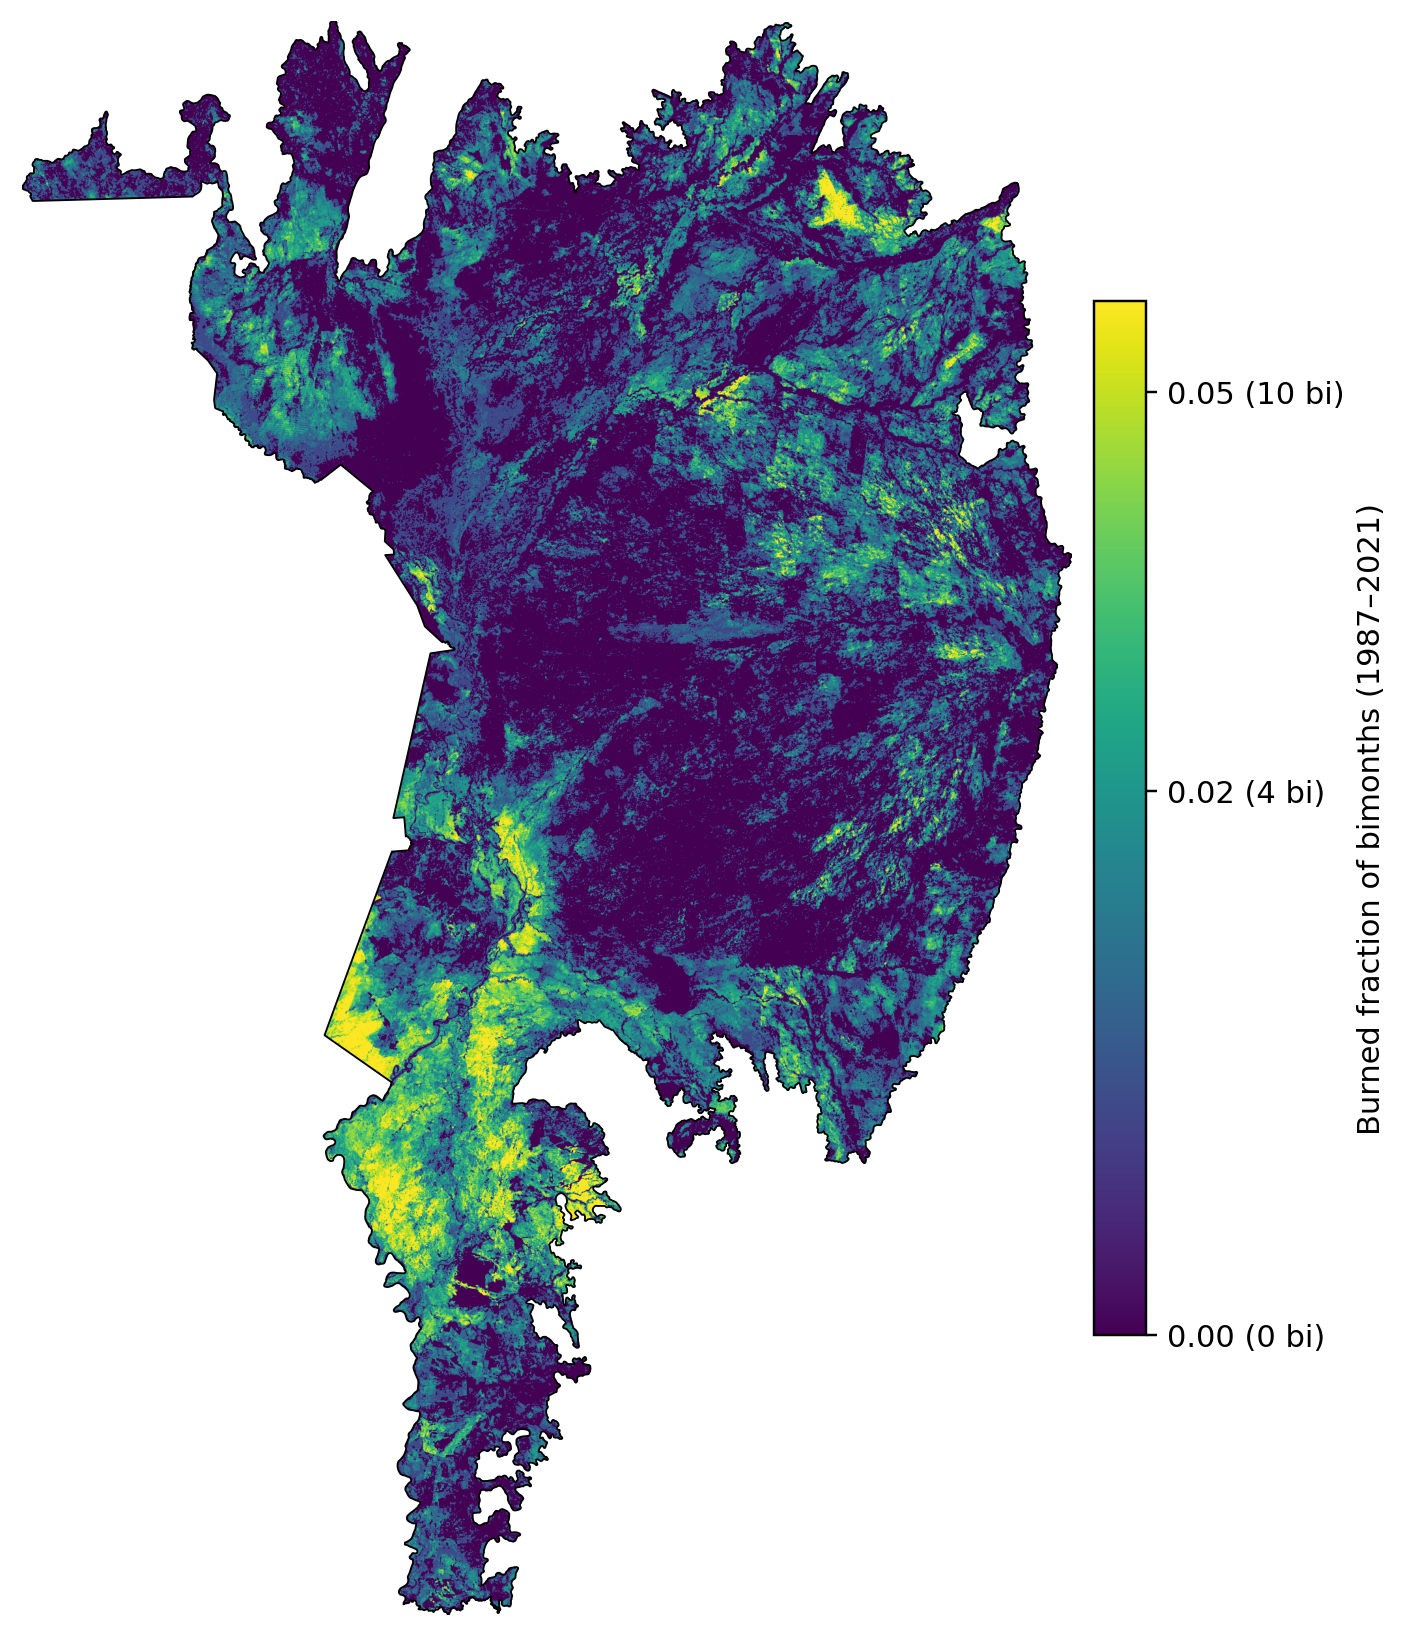

In [ ]:
# @title Plot aprimorado — Burn frequency (1987–2021) [FIX do norm/vmin/vmax]
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import PowerNorm

# === entradas
frac_clip_fp = REC_DIR / "fire_fraction_1987_2021_clip.tif"  # 0–1, já clipado
as_percent   = False     # True → mostra em %
gamma        = 0.6
dpi_out      = 220

# === ler raster e extent
with rio.open(frac_clip_fp) as ds:
    A   = ds.read(1)
    tfm = ds.transform
    crs = ds.crs
    H,W = ds.height, ds.width

left, right  = tfm.c, tfm.c + tfm.a * W
top,  bottom = tfm.f, tfm.f + tfm.e * H

# === contorno do Pantanal
gdf = gpd.read_file(BOUNDARY_PATH).to_crs(crs)

# === faixa dinâmica (recorta p99 para dar contraste)
vmin_raw = 0.0
vmax_raw = float(np.nanpercentile(A, 99)) if np.isfinite(A).any() else 1.0
if vmax_raw < 0.05:
    vmax_raw = 0.05

# preparar dados/escala
if as_percent:
    data_plot = A * 100.0
    vmin_plot = vmin_raw * 100.0
    vmax_plot = vmax_raw * 100.0
    cbar_label = "percent (%)"
else:
    data_plot = A.copy()
    vmin_plot = vmin_raw
    vmax_plot = vmax_raw
    cbar_label = "fraction (0–1)"

# === norm com vmin/vmax embutidos (NÃO passar vmin/vmax no imshow)
norm = PowerNorm(gamma=gamma, vmin=vmin_plot, vmax=vmax_plot)

# === plot
fig, ax = plt.subplots(figsize=(6.5, 9), dpi=dpi_out)
im = ax.imshow(
    data_plot,
    extent=(left, right, bottom, top),
    origin="upper",
    cmap="viridis",
    norm=norm
)

gdf.boundary.plot(ax=ax, color="k", linewidth=0.6)
#ax.set_title(
    #"Mapbiomas Burn frequency (1987–2021) — fraction of bimonths\n"
   # "(rule: mode==1 AND frac≥0.25)", fontsize=12, pad=10
#)
ax.set_axis_off()

#cb = plt.colorbar(im, ax=ax, fraction=0.045, pad=0.02)
#cb.set_label(cbar_label)
# ticks simples e legíveis
#ticks = np.linspace(vmin_plot, vmax_plot, 5)
#cb.set_ticks(ticks)

# coloque isso onde você cria a colorbar, após plt.colorbar(...)
ticks_frac = [0.00, 0.02, 0.05]
ticks_bims = [int(t*206) for t in ticks_frac]  # 206 bimestres (1987–2021)
cb = plt.colorbar(im, fraction=0.046, pad=0.02)  # 'im' é o handle do imshow
cb.set_ticks(ticks_frac)
cb.set_ticklabels([f"{t:.2f} ({b} bi)" for t,b in zip(ticks_frac, ticks_bims)])
cb.set_label("Burned fraction of bimonths (1987–2021)")

plt.tight_layout()
png_fp = REC_DIR / ("burn_frequency_1987_2021_percent.png" if as_percent
                    else "burn_frequency_1987_2021_fraction.png")
plt.savefig(png_fp, dpi=dpi_out, bbox_inches="tight")
print("✔ Figure saved:", png_fp)
plt.show()


In [ ]:
# @title B2-CHECK — Auditoria dos bimestrais MapBiomas (30 m e 300 m) + alinhamento
import re, glob
from pathlib import Path
import numpy as np, pandas as pd, geopandas as gpd
import rasterio as rio
from rasterio.features import rasterize
import matplotlib.pyplot as plt

assert 'MB_OUT_DIR' in globals(), "Defina MB_OUT_DIR (pasta de saída dos MB bimestrais)."
assert 'REF_FP' in globals(), "Defina REF_FP (raster de referência 300 m)."
assert 'BOUNDARY_PATH' in globals(), "Defina BOUNDARY_PATH (shp/gpkg do Pantanal)."

# 1) Referência 300 m
with rio.open(REF_FP) as ref:
    REF_CRS  = ref.crs
    REF_TFM  = ref.transform
    REF_H, REF_W = ref.height, ref.width

# 2) Descobrir todos os YYYYMM presentes em qualquer padrão conhecido
def _ym_from_name(name: str):
    m = re.search(r"(19|20)\d{2}(0[1-9]|1[0-2])", name)
    return m.group(0) if m else None

all_files = list(MB_OUT_DIR.glob("*.tif"))
by_ym = {}
for p in all_files:
    ym = _ym_from_name(p.name)
    if ym:
        by_ym.setdefault(ym, []).append(p)

YMS_FOUND = sorted(by_ym.keys())
print(f"YYYYMM encontrados na pasta: {len(YMS_FOUND)}")
print("Amostra:", YMS_FOUND[:10])

# 3) Funções auxiliares
def _open_stats(fp):
    with rio.open(fp) as ds:
        a   = ds.read(1)
        crs = ds.crs; tfm = ds.transform; H, W = ds.height, ds.width
        nod = ds.nodata
    if nod is not None:
        a = np.where(a==nod, np.nan, a)
    return a, crs, tfm, H, W

def _aligned(crs, tfm, H, W):
    return (crs == REF_CRS) and (tfm == REF_TFM) and (H == REF_H) and (W == REF_W)

# 4) Máscara Pantanal na grade REF (para métricas “dentro”)
gdf = gpd.read_file(BOUNDARY_PATH).to_crs(REF_CRS)
MASK_REF = rasterize([(g,1) for g in gdf.geometry if g is not None and not g.is_empty],
                     out_shape=(REF_H, REF_W), transform=REF_TFM, fill=0, dtype="uint8").astype(bool)

# 5) Auditar por YYYYMM
rows=[]
for ym in YMS_FOUND:
    # localizar paths por tipo
    p30   = next((p for p in by_ym[ym] if p.name.endswith("_30m.tif")), None)
    pfrac = next((p for p in by_ym[ym] if p.name.endswith("_300m_frac.tif")), None)
    pmode = next((p for p in by_ym[ym] if p.name.endswith("_300m_mode.tif")), None)
    # fallback (caso tenha sido salvo co
